### Edgar Moises Hernandez-Gonzalez
#### 16/04/20-17/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x4
##### Data Augmentation
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 17 22:18:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)

In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((6048,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #6048 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(6048, 264, 4)
(6048, 264, 4)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

67.42340492222856
55.28679494298277
0.00015417410020847705
0.00044794910241258623
1.1814394923763425
1.183555617428332


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 68.0
x_test /= 68.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9915207
0.81304115
2.2672662e-06
6.587487e-06
0.017374111
0.017405225


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 264, 4, 1)
(6048, 264, 4, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  1.1369477286146432
accuracy:  0.6026785969734192
kappa:  0.47023809523809523
confusion matrix:
 [[ 871  366  161  114]
 [ 431  864  176   41]
 [  81   35  850  546]
 [  49   13  390 1060]]


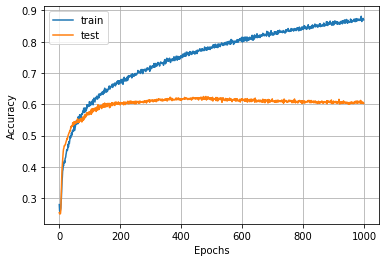

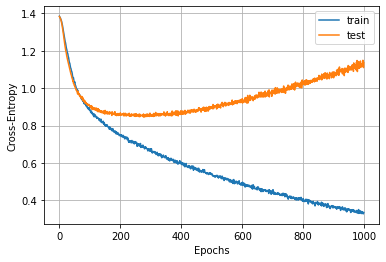

Iteration: 2
loss:  1.090593446489601
accuracy:  0.6049934029579163
kappa:  0.47332451499118167
confusion matrix:
 [[ 931  330  134  117]
 [ 467  842  158   45]
 [ 131   32  853  496]
 [  69   12  398 1033]]


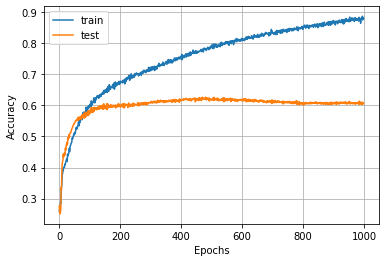

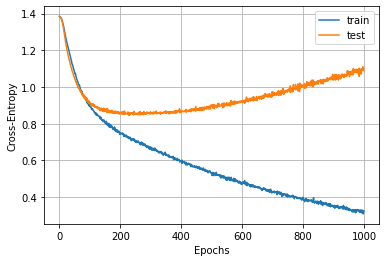

Iteration: 3
loss:  1.1670845847911935
accuracy:  0.5992063283920288
kappa:  0.4656084656084656
confusion matrix:
 [[ 864  316  181  151]
 [ 446  813  187   66]
 [  70   33  848  561]
 [  40    7  366 1099]]


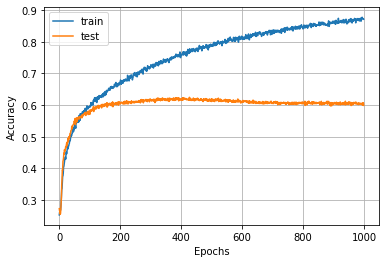

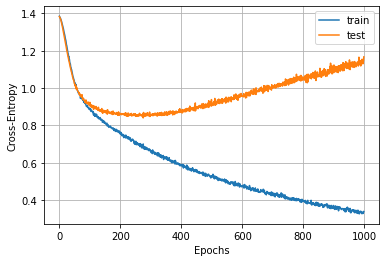

Iteration: 4
loss:  1.1735383736945333
accuracy:  0.5904431343078613
kappa:  0.45392416225749554
confusion matrix:
 [[ 870  324  194  124]
 [ 432  822  206   52]
 [  76   35  865  536]
 [  42    7  449 1014]]


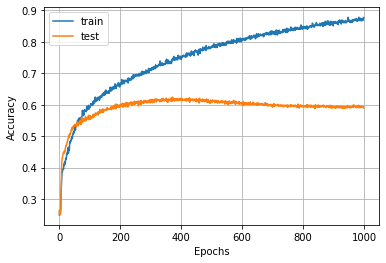

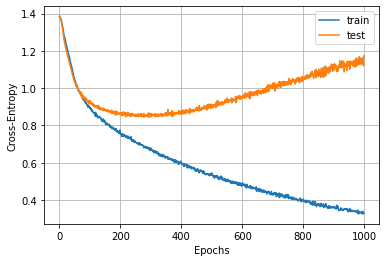

Iteration: 5
loss:  1.076236495738307
accuracy:  0.61557537317276
kappa:  0.48743386243386244
confusion matrix:
 [[ 920  314  154  124]
 [ 429  868  166   49]
 [  85   35  883  509]
 [  58    5  397 1052]]


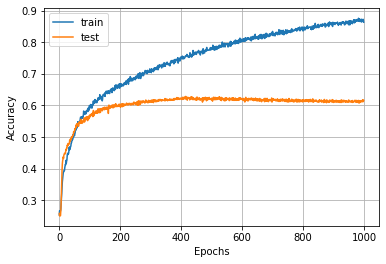

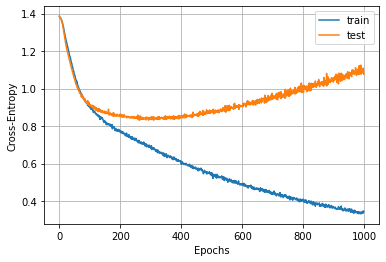


Resultados:
loss: [1.1369477286146432, 1.090593446489601, 1.1670845847911935, 1.1735383736945333, 1.076236495738307]
accuracy: [0.6026785969734192, 0.6049934029579163, 0.5992063283920288, 0.5904431343078613, 0.61557537317276]
kappa: [0.47023809523809523, 0.47332451499118167, 0.4656084656084656, 0.45392416225749554, 0.48743386243386244]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=512),
                                steps_per_epoch=np.ceil(n_samples_train/512),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 264, 4, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 132, 2, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 132, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 66, 1, 16)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                67648     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6026
std: (+/- 0.0082)
Mean Kappa: 0.4701
std: (+/- 0.0109)
Max Accuracy: 0.6156
Max Kappa: 0.4874
